In [5]:
%load_ext autoreload
%matplotlib inline

import sys
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from seaborn import despine

# nonstandard imports
from fooof import FOOOF
from neurodsp import spectral

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
datafolder = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120802PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session1/'
chan = 127
data_exmp = io.loadmat(datafolder+'ECoG_ch%i.mat'%chan, squeeze_me=True)['ECoGData_ch%i'%chan]
cond = io.loadmat(datafolder+'Condition.mat', squeeze_me=True)
data = data_exmp[cond['ConditionIndex'][0]:cond['ConditionIndex'][1]]
fs = 1000


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

18.016591117464287 0.008833798916467574 2.8796928146504994


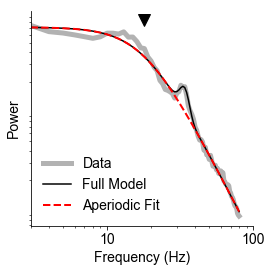

In [76]:
fit_range=[3,80]
plt_inds = np.arange(fit_range[0],fit_range[1]+1)
faxis, psd = spectral.compute_spectrum(data,fs,avg_type='median')

# fit fooof without knee
fo0 = FOOOF(max_n_peaks=1, aperiodic_mode='fixed')
fo0.fit(faxis, psd, fit_range)

# fit fooof with knee
fok = FOOOF(max_n_peaks=1, aperiodic_mode='knee')
fok.fit(faxis, psd, fit_range)
offset, knee, exp = fok.get_params('aperiodic_params')
kfreq, tau = echo_utils.convert_knee_val(knee,exp)
print(kfreq, tau, exp)

plt.figure(figsize=(4,4))
plt.loglog(faxis[plt_inds], psd[plt_inds], 'k', lw=5, alpha=0.3)
#plt.loglog(faxis[plt_inds], 10**fo0.fooofed_spectrum_)
plt.loglog(faxis[plt_inds], 10**fok.fooofed_spectrum_, 'k-')
despine()


plt.loglog(faxis[plt_inds], 10**offset/(knee+faxis**exp)[plt_inds], '--r', lw=2)
plt.xlim([3,100])
plt.xlabel('Frequency (Hz)');plt.ylabel('Power');
plt.xticks([10, 100], ['10', '100']);plt.yticks([]);
plt.legend(['Data', 'Full Model', 'Aperiodic Fit'], frameon=False)
plt.plot(kfreq, plt.ylim()[1]*0.9, 'vk', ms=12)

plt.tight_layout()


In [64]:
# compute autocorrelation function
max_lag=251
acf = np.zeros(max_lag)
acf[0] = np.corrcoef(data,data)[0,1]
for lag in range(1,max_lag):
    acf[lag] = np.corrcoef(data[lag:],data[:-lag])[0,1]

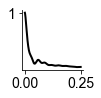

In [79]:
# plot a tiny autocorrelation function for inset
t_acf = np.arange(0,max_lag)/1000
plt.figure(figsize=(1.1,1.1))
plt.plot(t_acf, acf, 'k', lw=2)
plt.xticks([0,t_acf[-1]]); plt.yticks([1],['1'])
despine()

### some kind of modeling of spiking vs synaptic changes in AC?